In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path :
    sys.path.append(module_path)

    
import _ressources.chain as chain
import _ressources.tools as tools
import _ressources.lumenclass as lc

from scipy.optimize import curve_fit


main_dir = '/Users/mathieuleverge/git/chain_lumen/_data/pumping/'

In [2]:
def calc_mu(theta) :
    return np.sin(theta)**2 / (2*theta - np.sin(2*theta))

def calc_chi(theta, gamma, kappa, ell0, L0) :
    mu = calc_mu(theta)
    return 0.5*mu*np.sin(theta)*gamma*kappa / (ell0*L0**3)
    #return gamma*kappa / (ell0*L0**3)

def calc_chi(theta, eps, kappa, ell0, L0) :
    mu = calc_mu(theta)
    return 0.5*mu*np.sin(theta)*eps*kappa / (ell0*L0**3)
    #return mu*np.sin(theta)*eps / (L0*ell0**3)


def lin(x, a, b) :
    return a*x+b

def fit_lin(t, N) :
    x, y = np.log(t), np.log(N)
    popt, pcov = curve_fit(lin, x, y)
    alpha, kappa = popt[0], np.exp(popt[1])
    alpha_std, kappa_std = pcov[0, 0], np.exp(pcov[1, 1])
    return kappa, alpha#, kappa_std, alpha_std
    

In [3]:
def plot_pumping(ca, path_list, plot_param_list, Nt_list) :
    label = False
    Nt_list[ca] = {}
    for n in range(nsim) :
        Nt_list[ca][n] = np.loadtxt(os.path.join(path_list[ca][n], 'sim_nlum.dat'))
        if label :
            plt.plot(Nt_list[ca][n][:, 0], Nt_list[ca][n][:, 1], color=plot_param_list[ca][0], marker=plot_param_list[ca][1], markersize=plot_param_list[ca][2], linewidth=plot_param_list[ca][3])
        else :
            label = True
            plt.plot(Nt_list[ca][n][:, 0], Nt_list[ca][n][:, 1], color=plot_param_list[ca][0], marker=plot_param_list[ca][1], markersize=plot_param_list[ca][2], linewidth=plot_param_list[ca][3], label = r'$\Lambda_v$ = '+ str(ca))
    return Nt_list[ca]



# N(0) = 100

In [4]:
subdir = 'N100/ell10'
nsim=5

path_list_N100 = {}

# ca = 0
ca = 0
path_list_N100[ca] = {}
for n in range(nsim) :
    path_list_N100[ca][n] = os.path.join(main_dir, subdir, 'run'+str(ca)+'_'+str(n).zfill(4))

ca = 1e0
path_list_N100[ca] = {}
for n in range(nsim) :
    path_list_N100[ca][n] = os.path.join(main_dir, subdir, 'run1e0_'+str(n).zfill(4))
    
# ca = 1e-1
ca = 1e-1
path_list_N100[ca] = {}
for n in range(nsim) :
    path_list_N100[ca][n] = os.path.join(main_dir, subdir, 'run1e-1_'+str(n).zfill(4))
    
# ca = 1e-2
ca = 1e-2
path_list_N100[ca] = {}
for n in range(nsim) :
    path_list_N100[ca][n] = os.path.join(main_dir, subdir, 'run1e-2_'+str(n).zfill(4))
    
# ca = 1e-3
ca = 1e-3
path_list_N100[ca] = {}
for n in range(nsim) :
    path_list_N100[ca][n] = os.path.join(main_dir, subdir, 'run1e-3_'+str(n).zfill(4))
    
# ca = 1e-4
ca = 1e-4
path_list_N100[ca] = {}
for n in range(nsim) :
    path_list_N100[ca][n] = os.path.join(main_dir, subdir, 'run1e-4_'+str(n).zfill(4))

# ca = 1e-5
ca = 1e-5
path_list_N100[ca] = {}
for n in range(nsim) :
    path_list_N100[ca][n] = os.path.join(main_dir, subdir, 'run1e-5_'+str(n).zfill(4))
    

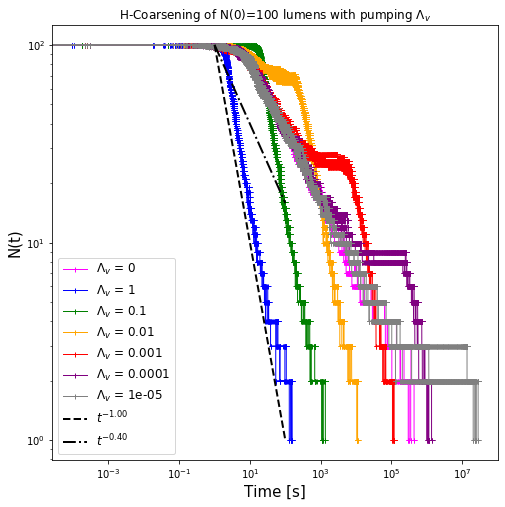

In [5]:
lw = 1
ms = 5

plot_param_list = {0 : ['magenta', '+', ms, lw], 
                   1 : ['blue', '+', ms, lw], 
                   1e-1 : ['green', '+', ms, lw], 
                   1e-2 : ['orange', '+', ms, lw], 
                   1e-3 :['red', '+', ms, lw], 
                   1e-4 :['purple', '+', ms, lw], 
                   1e-5 :['grey', '+', ms, lw]}

plt.figure(figsize=(8, 8))

plt.xscale('log')
plt.yscale('log')

nopump = 1
pump1e_0, pump1e_1, pump1e_2, pump1e_3, pump1e_4, pump1e_5 = 1, 1, 1, 1, 1, 1

Nt_list_N100 = {}

if nopump :
    ca = 0
    Nt_list_N100[ca] = plot_pumping(ca, path_list_N100, plot_param_list, Nt_list_N100)

if pump1e_0 :
    ca = 1
    Nt_list_N100[ca] = plot_pumping(ca, path_list_N100, plot_param_list, Nt_list_N100)
        
if pump1e_1 :
    ca = 1e-1
    Nt_list_N100[ca] = plot_pumping(ca, path_list_N100, plot_param_list, Nt_list_N100)
    
if pump1e_2 :
    ca = 1e-2
    Nt_list_N100[ca] = plot_pumping(ca, path_list_N100, plot_param_list, Nt_list_N100)
    
if pump1e_3 :
    ca = 1e-3
    Nt_list_N100[ca] = plot_pumping(ca, path_list_N100, plot_param_list, Nt_list_N100)
    
if pump1e_4 :
    ca = 1e-4
    Nt_list_N100[ca] = plot_pumping(ca, path_list_N100, plot_param_list, Nt_list_N100)
    
if pump1e_5 :
    ca = 1e-5
    Nt_list_N100[ca] = plot_pumping(ca, path_list_N100, plot_param_list, Nt_list_N100)



k1, a1 = 100, -1.
t1 = np.logspace(0, 2, 101)
plt.plot(t1, k1*t1**a1, label = r'$t^{'+"{:2.2f}".format(a1)+'}$', linewidth=2, linestyle='--', color = 'k')

k2, a2 = 100, -2./5.
t2 = np.logspace(0, 2, 101)
plt.plot(t2, k2*t2**a2, label = r'$t^{'+"{:2.2f}".format(a2)+'}$', linewidth=2, linestyle='-.', color = 'k')

plt.legend(loc=3, fontsize=12)

#plt.xlim(1e-1, 1e4)

plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('N(t)', fontsize=15)

plt.title(r'H-Coarsening of N(0)=100 lumens with pumping $\Lambda_v$')

plt.show()






## With pumping

Import successful !


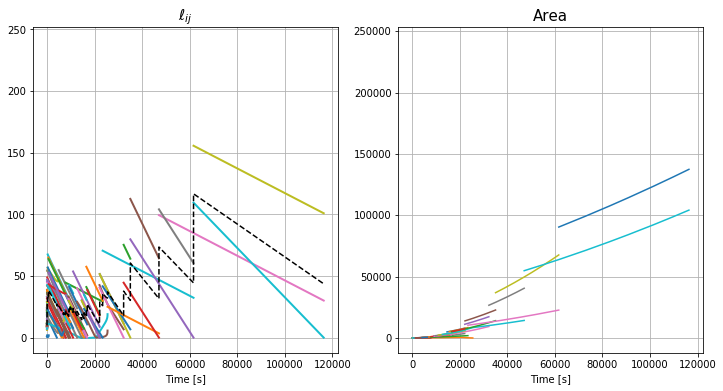

In [6]:

path_0 = os.path.join(main_dir, 'N100', 'ell10', 'run1e-3_0000')
L_pump_0, pos_pump_0 = tools.load_file(os.path.join(path_0, 'sim_all.dat'), hydroosmotic=False)

ell_pump_0 = tools.load_brfile(os.path.join(path_0, 'sim_bridges.dat'))


show_area=0
savefig=False
x_log = 0
y_log = 0

tools.plot_evolution_hydraulic(L_pump_0, ell_pump_0, savename='', show_totalarea=show_area, savefig=savefig, x_logscale=x_log, y_logscale=y_log, figsize=(12, 6))




## Without pumping

Import successful !


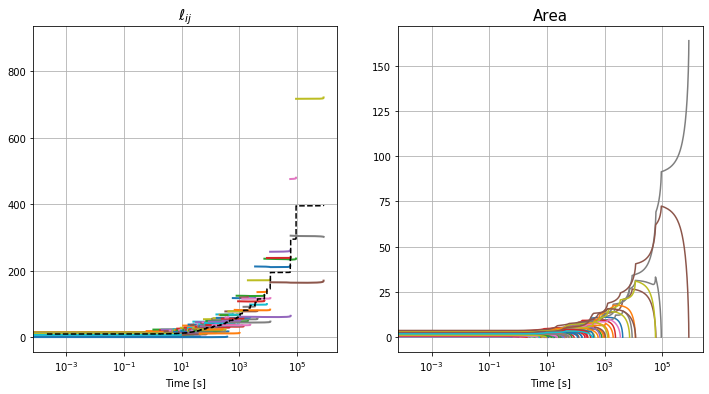

In [65]:

path_1 = os.path.join(main_dir, 'N100', 'ell10', 'run1e-3_0000_nopumping')
L_pump_1, pos_pump_1 = tools.load_file(os.path.join(path_1, 'sim_all.dat'), hydroosmotic=False)

ell_pump_1 = tools.load_brfile(os.path.join(path_1, 'sim_bridges.dat'))


show_area=0
savefig=0
x_log = 1
y_log = 0

savename = '/Users/mathieuleverge/Dropbox/M.Leverge/Lumen/Hydro-osmotic coarsening/Simulations/H-chain/N100_nopumping/evolution_linearscale.eps'
tools.plot_evolution_hydraulic(L_pump_1, ell_pump_1, savename=savename, show_totalarea=show_area, savefig=savefig, x_logscale=x_log, y_logscale=y_log, figsize=(12, 6))


## Distribution

In [8]:

path_1e0 = '/Users/mathieuleverge/git/chain_lumen/_data/pumping/N1000/ell10/ca1e0/run0000/'
L_1e0, pos_1e0 = tools.load_file(os.path.join(path_1e0, 'sim_all.dat'), hydroosmotic=False)

path_1e_1 = '/Users/mathieuleverge/git/chain_lumen/_data/pumping/N1000/ell10/ca1e-1/run0000/'
L_1e_1, pos_1e_1 = tools.load_file(os.path.join(path_1e_1, 'sim_all.dat'), hydroosmotic=False)

path_1e_2 = '/Users/mathieuleverge/git/chain_lumen/_data/pumping/N1000/ell10/ca1e-2/run0000/'
L_1e_2, pos_1e_2 = tools.load_file(os.path.join(path_1e_1, 'sim_all.dat'), hydroosmotic=False)

path_1e_3 = '/Users/mathieuleverge/git/chain_lumen/_data/pumping/N1000/ell10/ca1e-3/run0000/'
L_1e_3, pos_1e_3 = tools.load_file(os.path.join(path_1e_3, 'sim_all.dat'), hydroosmotic=False)

path_1e_4 = '/Users/mathieuleverge/git/chain_lumen/_data/pumping/N1000/ell10/ca1e-4/run0000/'
L_1e_4, pos_1e_4 = tools.load_file(os.path.join(path_1e_4, 'sim_all.dat'), hydroosmotic=False)

path_0 = '/Users/mathieuleverge/git/chain_lumen/_data/pumping/N1000/ell10/ca0/run0000/'
L_0, pos_0 = tools.load_file(os.path.join(path_0, 'sim_all.dat'), hydroosmotic=False)

#ell = tools.load_brfile(os.path.join(path, 'sim_bridges.dat'))

Import successful !
Import successful !
Import successful !
Import successful !
Import successful !
Import successful !


In [41]:
def clean_array(step, L) :
    array = L[step, 1:]
    cleaned_array = array[~np.isnan(array)]
    #print(len(cleaned_array))
    return cleaned_array

def distrib(step, L, bins=30, ax=None) :
    n=2.
    cleaned_array = clean_array(step, L)
    phi, x = np.histogram(cleaned_array, bins=bins)
    xbar = np.average(x)
    if ax != None :
        ax.plot(0.5*(x[1:]+x[:-1])/xbar, phi/np.sum(phi), label = "{:2.2e}".format(L[step,0]), alpha = 0.5*n)
    else :
        plt.plot(0.5*(x[1:]+x[:-1])/xbar, phi/np.sum(phi), label = "{:2.2e}".format(L[step,0]), alpha = 0.5*n)

    distrib = [0.5*(x[1:]+x[:-1])/xbar, phi/np.sum(phi)]
    
    return distrib

In [62]:
nbins = 15

In [63]:
Nt_0 = np.sum(L_0[:, 1:] >= 0., axis=1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app


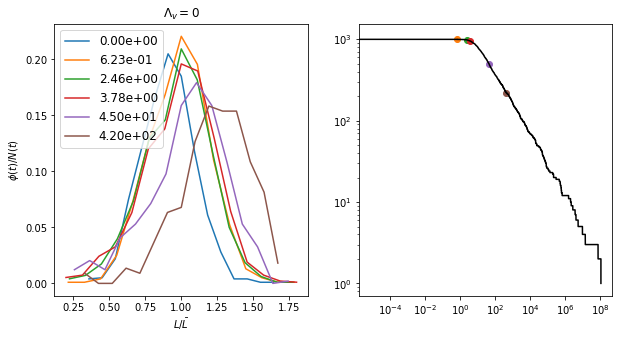

In [64]:
# Lv = 0
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
d_0 = {}
step_list = [0, 100, 500, 1000, 10000, 20000]

k=0
for s in step_list :
    d_0[s] = distrib(s, L_0, bins=nbins, ax=ax[0])
    k+=1
ax[0].set_title(r'$\Lambda_v = 0$')
ax[0].set_xlabel(r'$L/\bar{L}$')
ax[0].set_ylabel(r'$\phi(t) / N(t)$')
ax[0].legend(fontsize=12)

Nt_0 = np.sum(L_0[:, 1:] >= 0, axis=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].plot(L_0[:, 0], Nt_0, color = 'k')
for s in step_list :
    ax[1].scatter(L_0[s, 0], Nt_0[s])
plt.show()



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


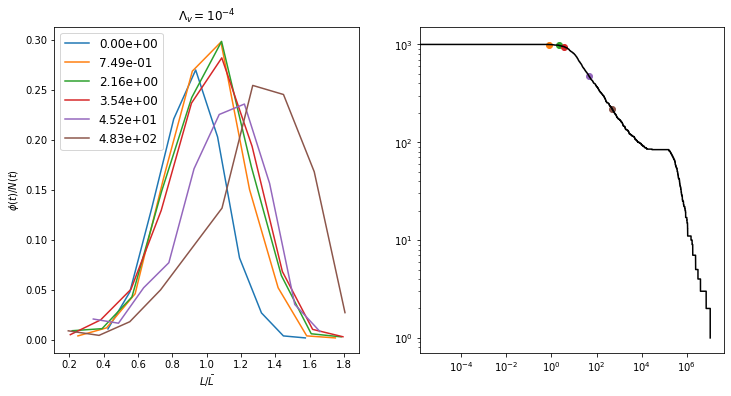

In [44]:
# Lv = 1e-4
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
d_1e_4 = {}
step_list = [0, 100, 500, 1000, 10000, 20000]

k=0
for s in step_list :
    d_1e_4 = distrib(s, L_1e_4, bins=nbins, ax=ax[0])
    k+=1
ax[0].set_title(r'$\Lambda_v = 10^{-4}$')
ax[0].set_xlabel(r'$L/\bar{L}$')
ax[0].set_ylabel(r'$\phi(t) / N(t)$')
ax[0].legend(fontsize=12)

Nt_1e_4 = np.sum(L_1e_4[:, 1:] > 0, axis=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].plot(L_1e_4[:, 0], Nt_1e_4, color = 'k')
for s in step_list :
    ax[1].scatter(L_1e_4[s, 0], Nt_1e_4[s])
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


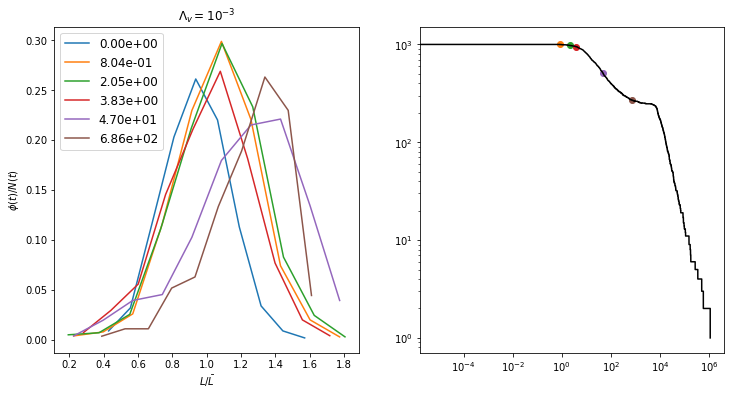

In [45]:
# Lv = 1e-3
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
d_1e_3 = {}
step_list = [0, 100, 500, 1000, 10000, 20000]

k=0
for s in step_list :
    d_1e_3 = distrib(s, L_1e_3, bins=nbins, ax=ax[0])
    k+=1
ax[0].set_title(r'$\Lambda_v = 10^{-3}$')
ax[0].set_xlabel(r'$L/\bar{L}$')
ax[0].set_ylabel(r'$\phi(t) / N(t)$')
ax[0].legend(fontsize=12)

Nt_1e_3 = np.sum(L_1e_3[:, 1:] > 0, axis=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].plot(L_1e_3[:, 0], Nt_1e_3, color = 'k')
for s in step_list :
    ax[1].scatter(L_1e_3[s, 0], Nt_1e_3[s])
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


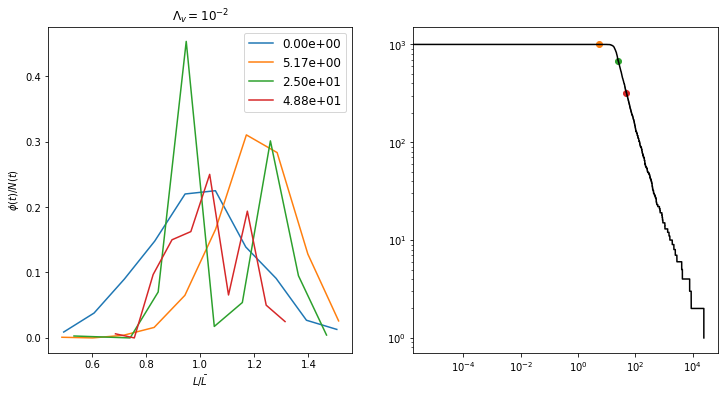

In [46]:
# Lv = 1e-2
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
d_1e_2 = {}
step_list = [0, 100, 500, 1000]

k=0
for s in step_list :
    d_1e_2 = distrib(s, L_1e_2, bins=nbins, ax=ax[0])
    k+=1
ax[0].set_title(r'$\Lambda_v = 10^{-2}$')
ax[0].set_xlabel(r'$L/\bar{L}$')
ax[0].set_ylabel(r'$\phi(t) / N(t)$')
ax[0].legend(fontsize=12)

Nt_1e_2 = np.sum(L_1e_2[:, 1:] > 0, axis=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].plot(L_1e_2[:, 0], Nt_1e_2, color = 'k')
for s in step_list :
    ax[1].scatter(L_1e_2[s, 0], Nt_1e_2[s])
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app


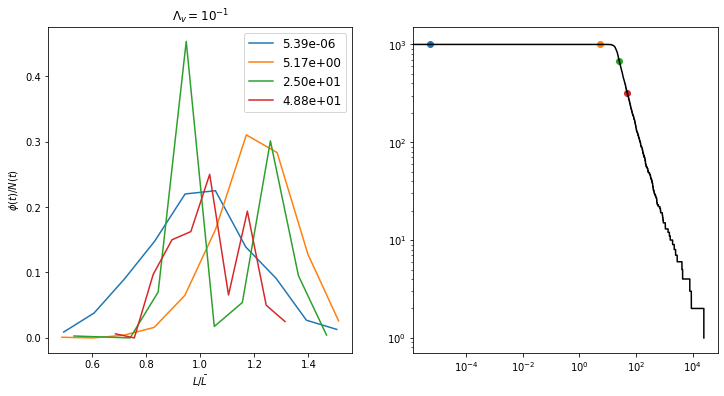

In [54]:
# Lv = 1e-1
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
d_1e_1 = {}
step_list = [1, 100, 500, 1000]

k=0
for s in step_list :
    d_1e_1 = distrib(s, L_1e_1, bins=nbins, ax=ax[0])
    k+=1
ax[0].set_title(r'$\Lambda_v = 10^{-1}$')
ax[0].set_xlabel(r'$L/\bar{L}$')
ax[0].set_ylabel(r'$\phi(t) / N(t)$')
ax[0].legend(fontsize=12)

Nt_1e_1 = np.sum(L_1e_1[:, 1:] >= 0, axis=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].plot(L_1e_1[:, 0], Nt_1e_1, color = 'k')
for s in step_list :
    ax[1].scatter(L_1e_1[s, 0], Nt_1e_1[s])
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


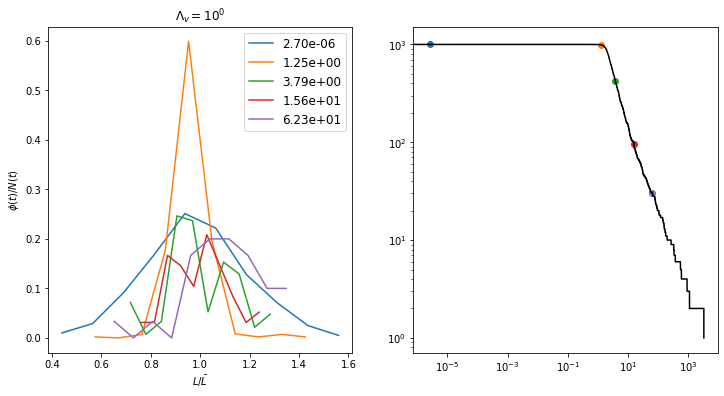

In [52]:

# Lv = 1e0
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
d_1e0 = {}
step_list = [1, 100, 500, 1000, 1200]

k=0
for s in step_list :
    d_1e0 = distrib(s, L_1e0, bins=nbins, ax=ax[0])
    k+=1
ax[0].set_title(r'$\Lambda_v = 10^{0}$')
ax[0].set_xlabel(r'$L/\bar{L}$')
ax[0].set_ylabel(r'$\phi(t) / N(t)$')
ax[0].legend(fontsize=12)

Nt_1e0 = np.sum(L_1e0[:, 1:] > 0, axis=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].plot(L_1e0[:, 0], Nt_1e0, color = 'k')
for s in step_list :
    ax[1].scatter(L_1e0[s, 0], Nt_1e0[s])
plt.show()


# N(0) = 1000

In [13]:
subdir = 'N1000/ell10'
nsim=20 

path_list_N1000 = {}

# ca = 0
ca = 0
subsubdir = 'ca0'
path_list_N1000[ca] = {}
for n in range(nsim) :
    path_list_N1000[0][n] = os.path.join(main_dir, subdir, subsubdir, 'run'+str(n).zfill(4))

# ca = 1
ca = 1
subsubdir = 'ca1e0'
path_list_N1000[ca] = {}
for n in range(nsim) :
    path_list_N1000[ca][n] = os.path.join(main_dir, subdir, subsubdir, 'run'+str(n).zfill(4))    

# ca = 1e-1
ca = 1e-1
subsubdir = 'ca1e-1'
path_list_N1000[ca] = {}
for n in range(nsim) :
    path_list_N1000[ca][n] = os.path.join(main_dir, subdir, subsubdir, 'run'+str(n).zfill(4))
    
# ca = 1e-2
ca = 1e-2
subsubdir = 'ca1e-2'
path_list_N1000[ca] = {}
for n in range(nsim) :
    path_list_N1000[ca][n] = os.path.join(main_dir, subdir, subsubdir, 'run'+str(n).zfill(4))
    
# ca = 1e-3
ca = 1e-3
subsubdir = 'ca1e-3'
path_list_N1000[ca] = {}
for n in range(nsim) :
    path_list_N1000[ca][n] = os.path.join(main_dir, subdir, subsubdir, 'run'+str(n).zfill(4))
    
# ca = 1e-4
ca = 1e-4
subsubdir = 'ca1e-4'
path_list_N1000[ca] = {}
for n in range(nsim) :
    path_list_N1000[ca][n] = os.path.join(main_dir, subdir, subsubdir, 'run'+str(n).zfill(4))
    
# ca = 1e-5
ca = 1e-5
subsubdir = 'ca1e-5'
path_list_N1000[ca] = {}
for n in range(nsim) :
    path_list_N1000[ca][n] = os.path.join(main_dir, subdir, subsubdir, 'run'+str(n).zfill(4))


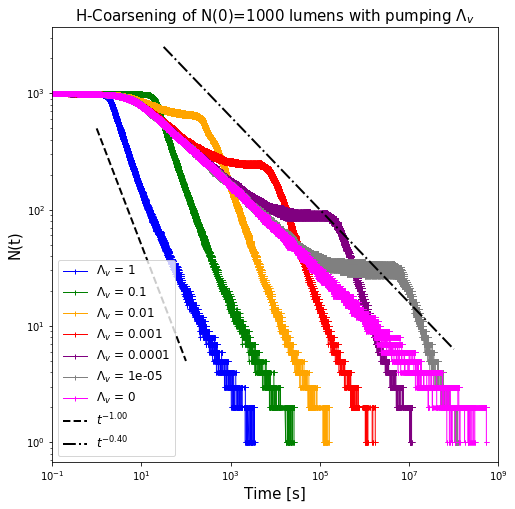

In [16]:
lw = 1
ms = 5

plot_param_list = {0 : ['magenta', '+', ms, lw], 
                   1 : ['blue', '+', ms, lw], 
                   1e-1 : ['green', '+', ms, lw], 
                   1e-2 : ['orange', '+', ms, lw], 
                   1e-3 :['red', '+', ms, lw], 
                   1e-4 :['purple', '+', ms, lw], 
                   1e-5 :['grey', '+', ms, lw]}

plt.figure(figsize=(8, 8))

plt.xscale('log')
plt.yscale('log')

nopump = 1
pump1e_0, pump1e_1, pump1e_2, pump1e_3, pump1e_4, pump1e_5 = 1, 1, 1, 1, 1, 1

Nt_list_N1000 = {}

if pump1e_0 :
    ca = 1
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000)

        
if pump1e_1 :
    ca = 1e-1
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000)

    
if pump1e_2 :
    ca = 1e-2
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000)
    
if pump1e_3 :
    ca = 1e-3
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000)
    
if pump1e_4 :
    ca = 1e-4
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000)
    
if pump1e_5 :
    ca = 1e-5
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000)

if nopump :
    ca = 0
    Nt_list_N1000[ca] = plot_pumping(ca, path_list_N1000, plot_param_list, Nt_list_N1000)

k1, a1 = 500, -1.
t1 = np.logspace(0, 2, 101)
plt.plot(t1, k1*t1**a1, label = r'$t^{'+"{:2.2f}".format(a1)+'}$', linewidth=2, linestyle='--', color = 'k')

k2, a2 = 10000, -2./5.
t2 = np.logspace(1.5, 8, 101)
plt.plot(t2, k2*t2**a2, label = r'$t^{'+"{:2.2f}".format(a2)+'}$', linewidth=2, linestyle='-.', color = 'k')

plt.legend(loc=3, fontsize=12)

plt.xlim(1e-1, 1e9)

plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('N(t)', fontsize=15)

#plt.axis('equal')

plt.title(r'H-Coarsening of N(0)=1000 lumens with pumping $\Lambda_v$', fontsize=15)
#plt.savefig('H-coarsening_N1000_pumping.eps', format='eps', dpi=100)
#plt.savefig('H-coarsening_N1000_pumping.png', format='png', dpi=100)
plt.show()




# Distribution

In [1]:
main_dir

NameError: name 'main_dir' is not defined

In [ ]:

path_ca0 = os.path.join(main_dir, 'N100', 'ell10', 'run1e-3_0000')
L_pump_0, pos_pump_0 = tools.load_file(os.path.join(path_0, 'sim_all.dat'), hydroosmotic=False)

ell_pump_0 = tools.load_brfile(os.path.join(path_0, 'sim_bridges.dat'))


show_area=0
savefig=False
x_log = 0
y_log = 0

tools.plot_evolution_hydraulic(L_pump_0, ell_pump_0, savename='', show_totalarea=show_area, savefig=savefig, x_logscale=x_log, y_logscale=y_log, figsize=(12, 6))



